# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1234/1234), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 4056 (delta 1141), reused 1124 (delta 1124), pack-reused 2822
Receiving objects: 100% (4056/4056), 649.94 MiB | 36.06 MiB/s, done.
Resolving deltas: 100% (2386/2386), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f626c466740>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model_0 = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
#model_0 # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 83.3MB/s]


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [9]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [10]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 19.123 seconds


### Make predictions on the entire test dataset with the model

In [26]:
# TODO
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd

def predict_values(model, dataloader, device):

  model.eval()
  softmax = nn.Softmax(dim=1)
  preds = torch.empty((0,), dtype=torch.float).to(device)
  target = torch.empty((0,), dtype=torch.float).to(device)
  probs = torch.empty((0,), dtype=torch.float).to(device)
  imgs = torch.empty((0,), dtype=torch.float).to(device)

  with torch.inference_mode():
    for X, y in dataloader:

      X, y = X.to(device), y.to(device)

      y_logits = model(X)
      y_probs = softmax(y_logits)
      y_preds = torch.argmax(y_probs, dim=1)
      y_preds_prob = torch.max(y_probs, dim=1)

      preds = torch.cat((preds, y_preds), dim=0)
      target = torch.cat((target, y), dim=0)
      probs = torch.cat((probs, y_preds_prob.values), dim=0)
      imgs = torch.cat((imgs, X), dim=0)

  prediction_df = pd.DataFrame({'label': target.cpu().to(torch.int64), 'prediction': preds.cpu().to(torch.int64), 'pred_prob': probs.cpu()})
  prediction_df['sample'] = range(0, len(prediction_df))

  return prediction_df, imgs

In [27]:
prediction_results, imgs = predict_values(model_0, test_dataloader, device)
prediction_results

,label,prediction,pred_prob,sample
0,0,0,0.734949,0
1,0,0,0.605592,1
2,0,0,0.466127,2
3,0,0,0.786989,3
4,0,0,0.402151,4
...,...,...,...,...
70,2,1,0.546966,70
71,2,2,0.539660,71
72,2,2,0.530035,72
73,2,2,0.450067,73


### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [16]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.2 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [17]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


<Axes: title={'center': 'Confusion Matrix'}>

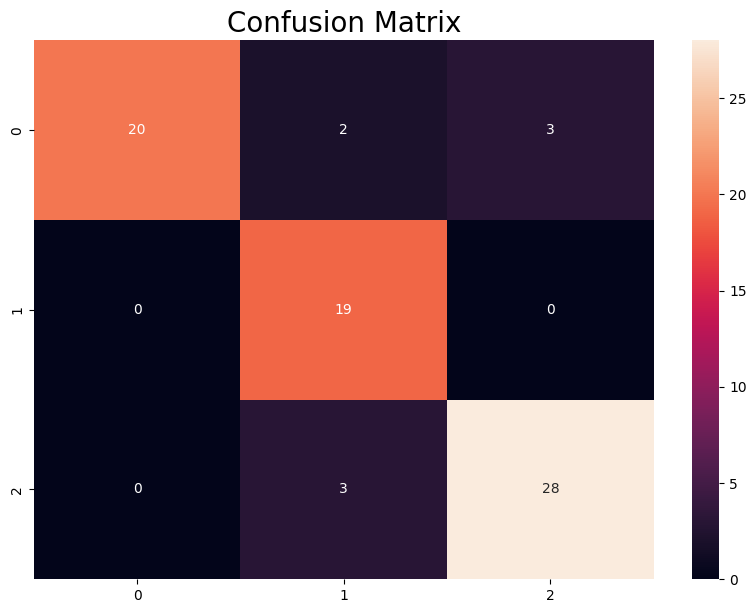

In [24]:
# TODO
import seaborn as sn

confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=3)
confmat_results = confmat(torch.tensor(prediction_results['prediction']), torch.tensor(prediction_results['label'])).cpu()

plt.figure(figsize = (10,7))
plt.axis(True)
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Test preds', fontsize=18)
plt.ylabel('Truth label', fontsize=16)
sn.heatmap(confmat_results, annot=True)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

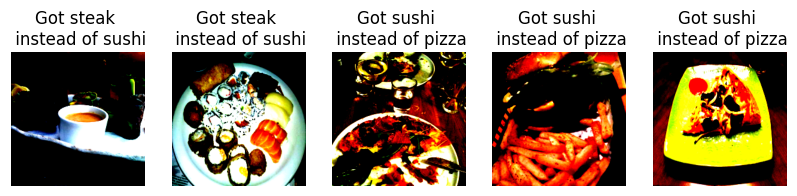

In [28]:
# TODO
import pandas as pd

plt.figure(figsize=(10, 7))
n_rows, n_columns, idx = 1, 5, 1

most_wrong_df = prediction_results[prediction_results.label != prediction_results.prediction].sort_values(by=['pred_prob'], ascending=False)

for i in range(5):
  plt.subplot(n_rows, n_columns, idx)
  plt.imshow(imgs[most_wrong_df['sample'].iloc[i]].cpu().permute(1,2,0))
  plt.axis(False)
  plt.title(f"Got {class_names[most_wrong_df['prediction'].iloc[i]]} \n instead of {class_names[most_wrong_df['label'].iloc[i]]}")
  idx += 1

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [49]:
from PIL import Image

def predict_single_image(model, img_path, label, transform, device):

  model.eval()
  with torch.inference_mode():

    img = Image.open(img_path)
    transformed_img = transform(img).unsqueeze(dim=0).to(device)

    softmax = nn.Softmax(dim=1)

    y_logits = model(transformed_img)
    y_probs =  softmax(y_logits)
    y_pred = torch.argmax(y_probs, dim=1)
    y_pred_prob = torch.max(y_probs, dim=1).values

  results = pd.DataFrame({'label': label, 'pred': class_names[y_pred.cpu()], 'pred prob': y_pred_prob.cpu()})

  return results

In [50]:
# TODO: Get an image of pizza/steak/sushi
predict_single_image(model_0, 'sushi.jpg', 'sushi', simple_transform, 'cuda')

,label,pred,pred prob
0,sushi,sushi,0.426783


In [52]:
# TODO: Get an image of not pizza/steak/sushi
predict_single_image(model_0, 'dog.jpg', 'dog', simple_transform, 'cuda')

,label,pred,pred prob
0,dog,sushi,0.386472


## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [54]:
# TODO: Recreate a new model
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

# Get new pretrained model
weights = EfficientNet_V2_S_Weights.DEFAULT
model_1 = efficientnet_v2_s(weights=weights)

preprocess = weights.transforms()

In [58]:
preprocess

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [56]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=preprocess, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f61be0a5090>,
 ['pizza', 'steak', 'sushi'])

In [57]:
for param in model_1.features.parameters():
    param.requires_grad = False

In [62]:
summary(model_1, input_size=(1, 3, 384, 384), col_names=("output_size", "num_params", "num_params", "trainable"))

Layer (type:depth-idx)                                  Output Shape              Param #                   Param #                   Trainable
EfficientNet                                            [1, 1000]                 --                        --                        Partial
├─Sequential: 1-1                                       [1, 1280, 12, 12]         --                        --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 24, 192, 192]         --                        --                        False
│    │    └─Conv2d: 3-1                                 [1, 24, 192, 192]         (648)                     (648)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 24, 192, 192]         (48)                      (48)                      False
│    │    └─SiLU: 3-3                                   [1, 24, 192, 192]         --                        --                        --
│    └─Sequential

It did not work with EfficientNet

In [63]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [64]:
# TODO: Train the model for 10 epochs
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [66]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6517 | train_acc: 0.8477 | test_loss: 0.5755 | test_acc: 0.8750
Epoch: 2 | train_loss: 0.5515 | train_acc: 0.9180 | test_loss: 0.5707 | test_acc: 0.9167
Epoch: 3 | train_loss: 0.5180 | train_acc: 0.8789 | test_loss: 0.5433 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.5340 | train_acc: 0.8008 | test_loss: 0.4681 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.5055 | train_acc: 0.8125 | test_loss: 0.4831 | test_acc: 0.8759
Epoch: 6 | train_loss: 0.4697 | train_acc: 0.8047 | test_loss: 0.4305 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.4144 | train_acc: 0.9531 | test_loss: 0.4445 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.4681 | train_acc: 0.8242 | test_loss: 0.4690 | test_acc: 0.7945
Epoch: 9 | train_loss: 0.4997 | train_acc: 0.8047 | test_loss: 0.4342 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.4199 | train_acc: 0.8164 | test_loss: 0.3460 | test_acc: 0.9062
Epoch: 11 | train_loss: 0.3725 | train_acc: 0.9219 | test_loss: 0.3661 | test_acc: 0.9271
Epoch: 12 | train_l

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [67]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [68]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [84]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=preprocess, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f61bdb42350>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [85]:
# TODO
from torchvision.models import EfficientNet_B1_Weights, efficientnet_b1

weights = EfficientNet_B1_Weights.DEFAULT
model_2 = efficientnet_b1(weights=weights)

In [86]:
weights.transforms()

ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [87]:
for param in model_2.features.parameters():
  param.requires_grad = False

In [88]:
summary(model_2, input_size=(1, 3, 224, 224), col_names=("output_size", "num_params", "num_params", "trainable"))

Layer (type:depth-idx)                                  Output Shape              Param #                   Param #                   Trainable
EfficientNet                                            [1, 1000]                 --                        --                        Partial
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --                        --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --                        --                        False
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         (864)                     (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         (64)                      (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --                        --                        --
│    └─Sequential

In [89]:
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train a model with 20% of the data

In [90]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [91]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0392 | train_acc: 0.5729 | test_loss: 0.9110 | test_acc: 0.9227
Epoch: 2 | train_loss: 0.8522 | train_acc: 0.8500 | test_loss: 0.7452 | test_acc: 0.9352
Epoch: 3 | train_loss: 0.7678 | train_acc: 0.8979 | test_loss: 0.6897 | test_acc: 0.9352
Epoch: 4 | train_loss: 0.6486 | train_acc: 0.9271 | test_loss: 0.5891 | test_acc: 0.9597
Epoch: 5 | train_loss: 0.5925 | train_acc: 0.9167 | test_loss: 0.5311 | test_acc: 0.9415
Epoch: 6 | train_loss: 0.5580 | train_acc: 0.8667 | test_loss: 0.4739 | test_acc: 0.9568
Epoch: 7 | train_loss: 0.5168 | train_acc: 0.8625 | test_loss: 0.4288 | test_acc: 0.9722
Epoch: 8 | train_loss: 0.5026 | train_acc: 0.8667 | test_loss: 0.4001 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.4135 | train_acc: 0.9208 | test_loss: 0.3689 | test_acc: 0.9568
Epoch: 10 | train_loss: 0.4533 | train_acc: 0.9000 | test_loss: 0.3663 | test_acc: 0.9477
[INFO] Total training time: 70.763 seconds
